## Interpolación de valores faltantes

Primero cargamos la información y limpiamos los datos, así ocmo calcular las variables necesarias. 

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

ruta_guardado = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\data_lake\PKL\dfs_final.pkl"

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
with open(ruta_guardado, 'rb') as f:
    dfs_final = pickle.load(f)

In [4]:
dfs = dfs_final

In [5]:
athletes_df = dfs['athletes_df']
athletes_events_df = dfs['athletes_events_df']
athletes_time_df = dfs['athletes_time_df']

issues_df = dfs['issues_df']
issues_events_df = dfs['issues_events_df']
issues_data_df = dfs['issues_data_df']
issues_times_df = dfs['issues_times_df']

In [6]:
athletes_events_df[['race_id', 'event_id']].drop_duplicates()

,race_id,event_id
0,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja
31679,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 1
31680,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 2
31681,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 3
31682,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 4
31683,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 5
31684,7679551d-2678-4f7c-9ee6-ee593e0f08d1,Stage 6
34415,8354870d-d6b7-46d6-946b-ed9c4406114a,Medio Maratón
59085,4675cb02-b97a-424b-a40f-49a961e02f58,Marato


In [7]:
athletes_time_df = dfs['athletes_time_df']

df = athletes_time_df.copy()

df['netTime_sec'] = df['netTime_td'].dt.total_seconds()

df = df.sort_values(['athlete_id', 'race_id', 'event_id', 'netTime_sec'])

df['prev_netTime'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['netTime_sec'].shift(1)
df['prev_split'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['split'].shift(1)

df['first_split'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount() == 0
df['time_split_sec'] = 0.0
df.loc[df['split'] == 'Salida', 'time_split_sec'] = 0.0

mask_first = df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_first, 'time_split_sec'] = df.loc[mask_first, 'netTime_sec']

mask_rest = ~df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_rest, 'time_split_sec'] = df.loc[mask_rest, 'netTime_sec'] - df.loc[mask_rest, 'prev_netTime']

athletes_time_df['time_split_sec'] = df['time_split_sec']
athletes_time_df['prev_split'] = df['prev_split']

negativos = df[df['time_split_sec'] < 0]
display(negativos[['athlete_id','race_id','event_id','prev_split','split','netTime_td','time_split_sec']])

,athlete_id,race_id,event_id,prev_split,split,netTime_td,time_split_sec


#### KNN clásico

Se usa para predecir una etiqueta o un valor de un dato nuevo.  
Se calcula la distancia entre el nuevo punto y los puntos del dataset.  
La predicción se hace por mayoría (clasificación) o promedio (regresión) de los k vecinos más cercanos.

**Fórmula regresión KNN:**

$\hat{y} = \frac{1}{k} \sum_{j \in N_i^k} y_j$

donde:

- $N_i^k$ son los k vecinos más cercanos al punto i en el dataset.

#### KNN Imputer (para imputación de datos faltantes)

Se aplica sobre un dataset con **NaN**.  
Para cada valor faltante $(x_{im} = \text{NaN})$, busca los k vecinos más cercanos que tengan ese valor presente y calcula un promedio ponderado para rellenarlo.

**Fórmula KNN Imputer:**

$\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}$

donde:

- $N_i^k(j)$ son los índices de los **k vecinos más cercanos** al atleta \(i\) que tienen el valor del split \(j\) disponible.
- $w_{il} = \frac{1}{d(i,l) + \epsilon}$ pondera por la distancia entre atletas en los splits conocidos.
- $d(i,l)$ puede ser, por ejemplo, la **distancia euclidiana** entre los vectores de splits existentes.

#### Naturaleza del problema

Consideremos un dataset donde cada fila representa a un atleta en un evento, y las columnas representan los tiempos en distintos splits (5K, 10K, 15K, 20K, Meta).  

Formalmente, la matriz de datos es:

$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1m} \\
x_{21} & x_{22} & \dots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nm}
\end{bmatrix}, \quad x_{ij} \in \mathbb{R} \cup \{\text{NaN}\}
$$

Algunas entradas $x_{ij}$ pueden ser **NaN** debido a que el atleta no completó un split, hubo error de registro, o no participó en un evento parcial.

#### Por qué usar KNN Imputer en lugar de KNN clásico

Mientras que el **KNN clásico** se utiliza para clasificación o regresión de nuevas observaciones completas, **KNN Imputer** está diseñado específicamente para manejar **valores faltantes (NaN)** dentro de un dataset existente.

En nuestro caso, queremos imputar splits faltantes de atletas en carreras, donde algunas filas tienen datos incompletos.  

##### KNN clásico

Para un nuevo punto i, la predicción de un valor y_i se hace promediando los k vecinos más cercanos:

**Limitación:** Este método requiere que la fila de entrada esté completa. No puede procesar filas con valores faltantes $(\text{NaN})$ sin eliminarlas o rellenarlas primero.


##### KNN Imputer

Para un valor faltante \(x_{ij} = \text{NaN}\), KNN Imputer calcula:

$
\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}
$

**Ventajas en este contexto:**

1. **Manejo directo de valores faltantes:** No requiere eliminar filas incompletas.
2. **Similitud entre atletas:** Imputa usando vecinos que ya completaron ese split, reflejando patrones reales de rendimiento.
3. **Flexible ante datos dispersos:** Puede imputar aunque cada atleta tenga diferentes splits disponibles.
4. **Escalabilidad y coherencia:** Tras estandarizar los splits (por ejemplo con `StandardScaler`), las imputaciones respetan la proporción relativa de los tiempos entre splits.


#### Limitaciones

- **No captura dependencia temporal explícita:** Solo considera similitud de splits existentes, no la dinámica de tiempo entre splits consecutivos. Métodos secuenciales como GRU o Transformers pueden modelar mejor la evolución.
- **Sensibilidad a outliers:** Atletas con splits atípicos pueden alterar la imputación.
- **Requiere suficientes vecinos:** Para atletas con muchos splits faltantes o poco representados, la imputación puede ser menos precisa.

### Función: pasos principales

1. **Filtrado de eventos válidos**
   - Se seleccionan solo eventos de tipo `'media'` o `'maraton'` donde no faltan splits (`splitsMissing == 0`) ni hay splits consecutivos faltantes (`maxConsecutiveSplitsMissing == 0`). En esta prueba no incluimos carreras fuera de maraton debido a su mayor variabilidad en tiempos. 

2. **Selección y limpieza de columnas**
   - Se conservan columnas relevantes: `athlete_id`, `event_id`, `event_std`, `race_id`, `time_split_sec`, `prev_split`, `distance`, `split`.
   - Se eliminan los splits de salida (`split != 'Salida'`) y filas con `time_split_sec` faltante.

3. **Filtrado opcional por carrera**
   - Si se especifica `race_id_filter`, se filtran solo los datos de esa carrera.

4. **Transformación a formato ancho**
   - Cada fila representa un atleta en un evento/carrera.
   - Las columnas corresponden a los splits (`5K`, `10K`, `15K`, `20K`, `Meta`) y los valores son `time_split_sec`.

5. **Estandarización de splits**

6. **Introducción de NaN artificiales**

7. **Imputación con KNN Imputer**
   - Se usa `KNNImputer` con vecinos ponderados por distancia (`weights='distance'`) para rellenar los valores faltantes en los splits.

8. **Cálculo de errores**
    - Se compara el valor real vs imputado en escala estandarizada.
    - Se calcula el error absoluto promedio (`mae_scaled`).


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, 
    nan_fraction=0.05, race_id_filter=None, neighbors_options=[5,10,15,20,25,30,50,100,200]
):
    
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(['media', 'maraton']))
    ][['athlete_id', 'event_id', 'event_std', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]

    df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id'], how='inner')
    df_merged = df_merged.merge(athletes_df[['athlete_id', 'gender', 'birthdate']], on='athlete_id', how='left')
    
    if 'race_id_y' in df_merged.columns:
        df_merged.rename(columns={'race_id_y': 'race_id'}, inplace=True)
    elif 'race_id_x' in df_merged.columns:
        df_merged.rename(columns={'race_id_x': 'race_id'}, inplace=True)

    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'event_std', 'time_split_sec',
                    'split', 'rawTime', 'gender', 'birthdate']
    cols_to_keep = [c for c in cols_to_keep if c in df_merged.columns]
    df_subset = df_merged[cols_to_keep].copy()
    df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'rawTime', 'birthdate'])
    
    if race_id_filter is not None:
        if 'race_id' in df_subset.columns:
            df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        else:
            logging.warning("race_id no encontrado en df_subset, se ignora el filtrado")
    
    df_wide = df_subset.pivot_table(index=['athlete_id', 'race_id', 'event_id'],
                                    columns='split', values='time_split_sec')
    df_wide.reset_index(inplace=True)

    athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'rawTime']].reset_index()
    athletes_info['birthdate'] = pd.to_datetime(athletes_info['birthdate'])
    athletes_info['race_date'] = pd.to_datetime(athletes_info['rawTime'])
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')
    
    splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']

    df_splits_sec = df_wide[splits_to_keep].copy()

    scaler = StandardScaler()
    df_scaled = df_wide.copy()
    df_scaled[splits_to_keep] = scaler.fit_transform(df_wide[splits_to_keep])

    df_scaled_filtered = df_scaled.copy()  

    n_missing = int(nan_fraction * len(df_scaled_filtered))
    rows_to_nan = np.random.choice(df_scaled_filtered.index, size=n_missing, replace=False)
    nan_value_dict_sec = {split: pd.Series(np.nan, index=df_scaled_filtered.index) for split in splits_to_keep}
    
    for row in rows_to_nan:
        available_cols = df_scaled_filtered.loc[row, splits_to_keep].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            nan_value_dict_sec[col_to_nan].loc[row] = df_splits_sec.loc[row, col_to_nan]
            df_scaled_filtered.loc[row, col_to_nan] = np.nan

    best_mae = np.inf
    best_n = None
    best_imputed_scaled = None
    
    for n in neighbors_options:
        imputer = KNNImputer(n_neighbors=n, weights='distance', metric='nan_euclidean')
        df_imputed_trial = df_scaled_filtered.copy()
        df_imputed_trial[splits_to_keep] = imputer.fit_transform(df_scaled_filtered[splits_to_keep])
        df_imputed_trial_sec = df_imputed_trial.copy()
        df_imputed_trial_sec[splits_to_keep] = scaler.inverse_transform(df_imputed_trial[splits_to_keep])
        
        abs_errors = []
        for split in splits_to_keep:
            mask_nan = nan_value_dict_sec[split].notna()
            if mask_nan.any():
                abs_errors.append(
                    (df_imputed_trial_sec.loc[mask_nan, split] - nan_value_dict_sec[split][mask_nan]).abs()
                )
        mae_trial = pd.concat(abs_errors).mean()
        logging.info(f"n_neighbors={n}: MAE={mae_trial:.2f} seg")
        
        if mae_trial < best_mae:
            best_mae = mae_trial
            best_n = n
            best_imputed_scaled = df_imputed_trial.copy()

    logging.info(f"Mejor n_neighbors={best_n} con MAE={best_mae:.2f} seg")
    
    df_imputed_sec = best_imputed_scaled.copy()
    df_imputed_sec[splits_to_keep] = scaler.inverse_transform(best_imputed_scaled[splits_to_keep])
    
    comparison = pd.DataFrame(columns=['athlete_id', 'split', 'valor_real', 'valor_imputado', 'abs_error'])
    for split in splits_to_keep:
        mask_nan = nan_value_dict_sec[split].notna()
        if mask_nan.any():
            temp = pd.DataFrame({
                'athlete_id': df_scaled_filtered.loc[mask_nan, 'athlete_id'],
                'split': split,
                'valor_real': nan_value_dict_sec[split][mask_nan],
                'valor_imputado': df_imputed_sec.loc[mask_nan, split],
                'abs_error': (df_imputed_sec.loc[mask_nan, split] - nan_value_dict_sec[split][mask_nan]).abs()
            })
            comparison = pd.concat([comparison, temp], ignore_index=True)
    comparison = comparison.merge(df_scaled_filtered[['athlete_id','gender','age']], on='athlete_id', how='left')

    mae_overall = comparison['abs_error'].mean()
    mae_per_split = comparison.groupby('split')['abs_error'].mean().to_dict()
    logging.info(f"MAE por split (segundos): {mae_per_split}")
    logging.info(f"MAE general (segundos): {mae_overall:.2f}")

    plt.figure(figsize=(8,5))
    comparison.boxplot(column='abs_error', by='split')
    plt.ylabel('Error absoluto (segundos)')
    plt.title('Distribución de errores por split')
    plt.suptitle('')
    plt.show()

    plt.figure(figsize=(6,5))
    comparison.boxplot(column='abs_error', by='gender')
    plt.ylabel('Error absoluto (segundos)')
    plt.title('Distribución de errores por género')
    plt.suptitle('')
    plt.show()

    bins = [0,20,30,40,50,100]
    labels = ['<20','20-29','30-39','40-49','50+']
    comparison['age_group'] = pd.cut(comparison['age'], bins=bins, labels=labels)

    plt.figure(figsize=(8,5))
    comparison.boxplot(column='abs_error', by='age_group')
    plt.ylabel('Error absoluto (segundos)')
    plt.xlabel('Grupo de edad')
    plt.title('Distribución de errores por grupo de edad')
    plt.suptitle('')
    plt.show()

    plt.figure(figsize=(8,6))
    for split in splits_to_keep:
        subset = comparison[comparison['split'] == split]
        plt.scatter(subset['valor_real'], subset['valor_imputado'], alpha=0.6, label=split)

    plt.plot([comparison['valor_real'].min(), comparison['valor_real'].max()],
            [comparison['valor_real'].min(), comparison['valor_real'].max()],
            'k--', linewidth=1)
    plt.xlabel('Valor real (segundos)')
    plt.ylabel('Valor imputado (segundos)')
    plt.title('Valor real vs imputado por split')
    plt.legend(title='Split')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return df_imputed_sec, comparison, mae_per_split, mae_overall

INFO: n_neighbors=5: MAE=40.88 seg
INFO: n_neighbors=10: MAE=38.21 seg
INFO: n_neighbors=15: MAE=36.84 seg
INFO: n_neighbors=20: MAE=36.24 seg
INFO: n_neighbors=25: MAE=35.68 seg
INFO: n_neighbors=30: MAE=35.37 seg
INFO: n_neighbors=50: MAE=34.51 seg
INFO: n_neighbors=100: MAE=34.06 seg
INFO: n_neighbors=200: MAE=33.89 seg
INFO: Mejor n_neighbors=200 con MAE=33.89 seg
C:\Users\mario\AppData\Local\Temp\ipykernel_15652\1911915478.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison = pd.concat([comparison, temp], ignore_index=True)
INFO: MAE por split (segundos): {'10K': 31.124387132381496, '15K': 26.780040159898466, '20K': 48.385979106429, '5K': 47.537576625106055, 'Meta': 15.173731261334932}
INFO: MAE general (segundos): 33.89


<Figure size 800x500 with 0 Axes>

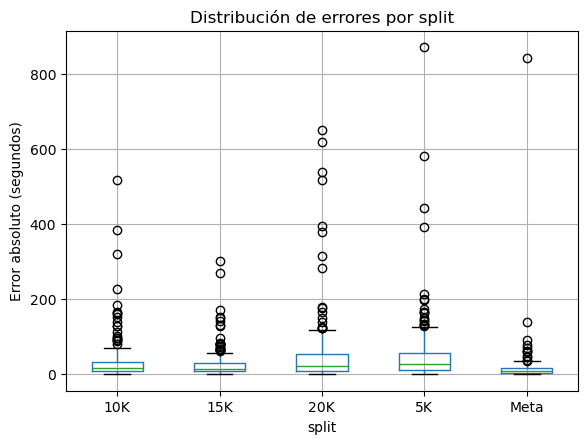

<Figure size 600x500 with 0 Axes>

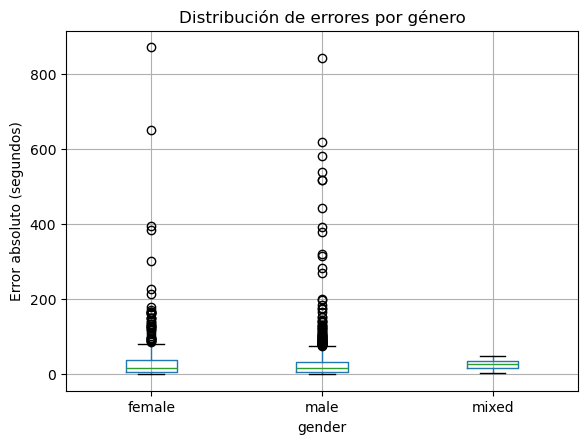

<Figure size 800x500 with 0 Axes>

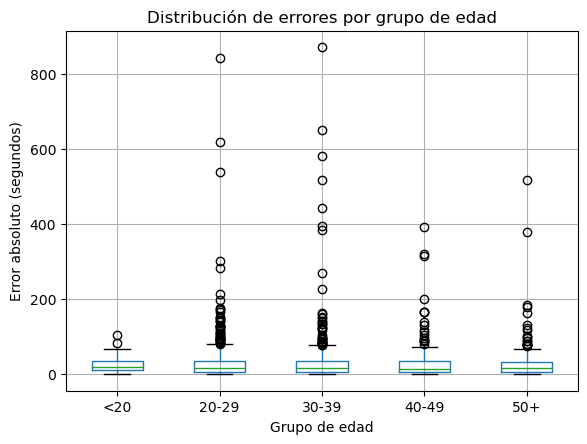

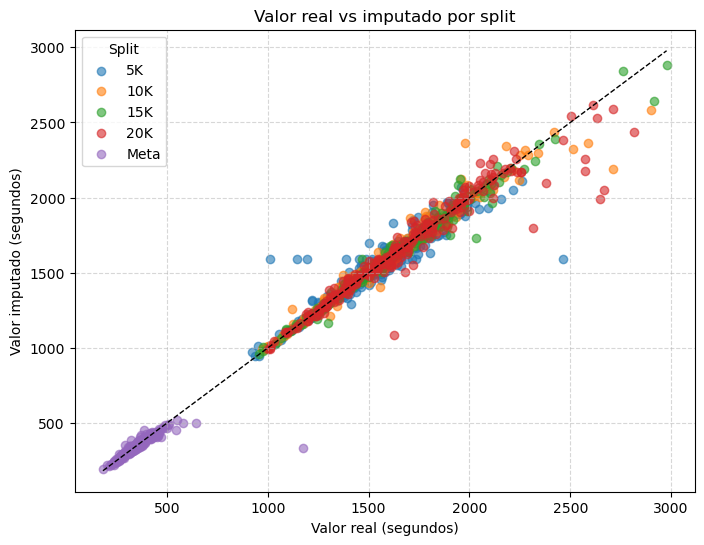

In [11]:
mae_scaled, mae_seconds, examples_min, mae_per_split = imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.05, race_id_filter='2fa6d70a-afef-4f4e-880e-deea01248d9b'
)

Podemos ver que para una media maratón, los splits que mejor predice son los finales. Eso tiene sentido ya que cuanbdo un atleta ha avanzado lo suficiente en una carrera ya se van separando de forma más precisa en grupos y clusters de rendimiento, pero al principio hay un poco de caos (no se sabe si su marcha será la de toda la carrera)

También vemos como los atletas jóvenes no tienen mucha variación en su error de imputación, aunque puede ser que se deba a que no tenemos muchos ejemplos de atletas así. 

Vemos cómo en la parte inicial y final de la carrera se d¡suelen cometer más errores por la forma del gráfico

Podemos ver como en la gran mayoría de los splits hay una error cercano al medio minuto

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, 
    nan_fraction=0.2, race_id_filter=None, neighbors_options=[5,10,15,20,25,30,50,100,200],
    event_std_filter='media'
):
    """
    Imputa valores de splits temporales de atletas usando KNN, considerando gender y age como features adicionales.
    Retorna:
    - df_imputed_sec: dataframe con splits imputados en segundos
    - comparison: dataframe de comparación entre valores reales y imputados
    - mae_per_split: diccionario con MAE por split
    - mae_overall: MAE general
    """
    logging.info("Filtrando eventos por splits completos y tipo de evento")
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'] == event_std_filter)
    ][['athlete_id', 'event_id', 'event_std', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]

    logging.info("Merge inicial para validación de splits")
    df_check_splits = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id'], how='inner')

    if race_id_filter is not None:
        if 'race_id' in df_check_splits.columns:
            df_check_splits = df_check_splits[df_check_splits['race_id'] == race_id_filter].copy()
            logging.info(f"Filtrado de carrera race_id={race_id_filter} para validación de splits")
        else:
            logging.warning("race_id no encontrado en df_check_splits, se ignora el filtrado")

    if 'race_id_y' in df_check_splits.columns:
        df_check_splits.rename(columns={'race_id_y': 'race_id'}, inplace=True)
    elif 'race_id_x' in df_check_splits.columns:
        df_check_splits.rename(columns={'race_id_x': 'race_id'}, inplace=True)

    if 'race_id' not in df_check_splits.columns:
        raise KeyError("La columna 'race_id' no se encontró después del merge. Revisa tus dataframes de entrada.")

    if race_id_filter is None:
        splits_per_event = df_check_splits.groupby('event_id')['split'].unique()
        split_sets = splits_per_event.apply(lambda x: tuple(sorted(x))).unique()  # convertir a tuplas
        if len(split_sets) > 1:
            raise ValueError(
                f"Los eventos seleccionados para event_std='{event_std_filter}' no tienen los mismos splits. "
                "Elige solo una carrera o verifica los splits."
            )
        else:
            logging.info(f"Todos los eventos para event_std='{event_std_filter}' tienen los mismos splits: {split_sets[0]}")

    logging.info("Merge de datos de tiempos y atletas")
    df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id'], how='inner')
    df_merged = df_merged.merge(athletes_df[['athlete_id', 'gender', 'birthdate']], on='athlete_id', how='left')

    if 'race_id_y' in df_merged.columns:
        df_merged.rename(columns={'race_id_y': 'race_id'}, inplace=True)
    elif 'race_id_x' in df_merged.columns:
        df_merged.rename(columns={'race_id_x': 'race_id'}, inplace=True)

    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'event_std', 'time_split_sec',
                    'split', 'rawTime', 'gender', 'birthdate']
    cols_to_keep = [c for c in cols_to_keep if c in df_merged.columns]
    df_subset = df_merged[cols_to_keep].copy()
    df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'rawTime', 'birthdate'])

    if race_id_filter is not None:
        if 'race_id' in df_subset.columns:
            df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
            logging.info(f"Filtrado por race_id={race_id_filter}, {len(df_subset)} filas restantes")
        else:
            logging.warning("race_id no encontrado en df_subset, se ignora el filtrado")


    logging.info("Pivotando para tener splits como columnas")
    df_wide = df_subset.pivot_table(index=['athlete_id', 'race_id', 'event_id'],
                                    columns='split', values='time_split_sec')
    df_wide.reset_index(inplace=True)

    logging.info("Calculando edad de los atletas y convirtiendo gender a numérico")
    athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'rawTime']].reset_index()
    athletes_info['birthdate'] = pd.to_datetime(athletes_info['birthdate'])
    athletes_info['race_date'] = pd.to_datetime(athletes_info['rawTime'])
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    athletes_info['gender'] = athletes_info['gender'].map({'M': 0, 'F': 1})
    df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')

    splits_to_keep = [c for c in df_wide.columns if c not in ['athlete_id', 'race_id', 'event_id', 'gender', 'age']]
    logging.info(f"Splits que se imputarán: {splits_to_keep}")

    scaler = StandardScaler()
    df_scaled = df_wide.copy()
    df_scaled[splits_to_keep] = scaler.fit_transform(df_wide[splits_to_keep])
    df_scaled_filtered = df_scaled.copy()

    logging.info("Generando NaN aleatorios solo en splits para validación")
    n_missing = int(nan_fraction * len(df_scaled_filtered))
    rows_to_nan = np.random.choice(df_scaled_filtered.index, size=n_missing, replace=False)
    nan_value_dict_sec = {split: pd.Series(np.nan, index=df_scaled_filtered.index) for split in splits_to_keep}
    for row in rows_to_nan:
        available_cols = df_scaled_filtered.loc[row, splits_to_keep].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            nan_value_dict_sec[col_to_nan].loc[row] = df_wide.loc[row, col_to_nan]
            df_scaled_filtered.loc[row, col_to_nan] = np.nan

    logging.info("Iniciando búsqueda del mejor n_neighbors para KNNImputer")
    best_mae = np.inf
    best_n = None
    best_imputed_scaled = None
    for n in neighbors_options:
        imputer = KNNImputer(n_neighbors=n, weights='distance', metric='nan_euclidean')
        imputed_array = imputer.fit_transform(df_scaled_filtered[splits_to_keep])
        df_imputed_trial = df_scaled_filtered.copy()
        df_imputed_trial[splits_to_keep] = imputed_array

        df_imputed_trial[splits_to_keep] = scaler.inverse_transform(df_imputed_trial[splits_to_keep])

        abs_errors = []
        for split in splits_to_keep:
            mask_nan = nan_value_dict_sec[split].notna()
            if mask_nan.any():
                abs_errors.append(
                    (df_imputed_trial.loc[mask_nan, split] - nan_value_dict_sec[split][mask_nan]).abs()
                )
        mae_trial = pd.concat(abs_errors).mean()
        logging.info(f"n_neighbors={n}: MAE={mae_trial:.2f} seg")
        if mae_trial < best_mae:
            best_mae = mae_trial
            best_n = n
            best_imputed_scaled = df_imputed_trial.copy()

    logging.info(f"Mejor n_neighbors={best_n} con MAE={best_mae:.2f} seg")
    df_imputed_sec = best_imputed_scaled.copy()

    comparison = pd.DataFrame(columns=['athlete_id', 'split', 'valor_real', 'valor_imputado', 'abs_error'])
    for split in splits_to_keep:
        mask_nan = nan_value_dict_sec[split].notna()
        if mask_nan.any():
            temp = pd.DataFrame({
                'athlete_id': df_scaled_filtered.loc[mask_nan, 'athlete_id'],
                'split': split,
                'valor_real': nan_value_dict_sec[split][mask_nan],
                'valor_imputado': df_imputed_sec.loc[mask_nan, split],
                'abs_error': (df_imputed_sec.loc[mask_nan, split] - nan_value_dict_sec[split][mask_nan]).abs()
            })
            comparison = pd.concat([comparison, temp], ignore_index=True)
    comparison = comparison.merge(df_scaled_filtered[['athlete_id','gender','age']], on='athlete_id', how='left')

    mae_overall = comparison['abs_error'].mean()
    mae_per_split = comparison.groupby('split')['abs_error'].mean().to_dict()
    logging.info(f"MAE por split (segundos): {mae_per_split}")
    logging.info(f"MAE general (segundos): {mae_overall:.2f}")

    return df_imputed_sec, comparison, mae_per_split, mae_overall

In [13]:
mae_scaled, mae_seconds, examples_min, mae_per_split = imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.2, race_id_filter='2fa6d70a-afef-4f4e-880e-deea01248d9b'
)

INFO: Filtrando eventos por splits completos y tipo de evento
INFO: Merge inicial para validación de splits
INFO: Merge de datos de tiempos y atletas
INFO: Filtrado por race_id=2fa6d70a-afef-4f4e-880e-deea01248d9b, 131828 filas restantes
INFO: Pivotando para tener splits como columnas
INFO: Calculando edad de los atletas y convirtiendo gender a numérico
INFO: Splits que se imputarán: ['10K', '15K', '20K', '5K', 'Meta']
INFO: Generando NaN aleatorios solo en splits para validación
INFO: Iniciando búsqueda del mejor n_neighbors para KNNImputer
INFO: n_neighbors=5: MAE=39.26 seg
INFO: n_neighbors=10: MAE=36.29 seg
INFO: n_neighbors=15: MAE=35.11 seg
INFO: n_neighbors=20: MAE=34.50 seg
INFO: n_neighbors=25: MAE=33.96 seg
INFO: n_neighbors=30: MAE=33.61 seg
INFO: n_neighbors=50: MAE=32.84 seg
INFO: n_neighbors=100: MAE=32.30 seg
INFO: n_neighbors=200: MAE=32.39 seg
INFO: Mejor n_neighbors=100 con MAE=32.30 seg
C:\Users\mario\AppData\Local\Temp\ipykernel_15652\4210268571.py:167: FutureWarnin

## Ajuste temporal

In [ ]:
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def extraer_datos_splits_completos(
    athletes_events_df, athletes_time_df, athletes_df,
    race_id_filter=None, event_std_filter='media'
):
    """
    Extrae splits completos y muestra columnas en cada DataFrame.
    """
    logging.info("=== athletes_events_df columnas ===")
    print(athletes_events_df.columns.tolist())

    logging.info("Filtrando eventos por splits completos y tipo de evento")
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'] == event_std_filter)
    ][['athlete_id', 'event_id', 'event_std', 'race_id']]
    logging.info("=== filtered_events columnas ===")
    print(filtered_events.columns.tolist())

    logging.info("Merge inicial para obtener tiempos y splits")
    df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id', 'race_id', 'event_std'], how='inner')
    logging.info("=== df_merged columnas después del merge con filtered_events ===")
    print(df_merged.columns.tolist())

    df_merged = df_merged.merge(athletes_df[['athlete_id', 'birthdate', 'gender']], on=['athlete_id'], how='left')
    logging.info("=== df_merged columnas después del merge con athletes_df ===")
    print(df_merged.columns.tolist())

    if race_id_filter is not None:
        if 'race_id' in df_merged.columns:
            df_merged = df_merged[df_merged['race_id'] == race_id_filter].copy()
            logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_merged)}")
        else:
            logging.warning("'race_id' no encontrado en df_merged, se omite filtrado")

    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
    df_subset = df_merged[[c for c in cols_to_keep if c in df_merged.columns]].copy()
    logging.info("=== df_subset columnas ===")
    print(df_subset.columns.tolist())

    df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'birthdate'])
    logging.info("=== df_subset columnas después de filtrar 'Salida' y NA ===")
    print(df_subset.columns.tolist())

    index_cols = ['athlete_id', 'event_id']
    if 'race_id' in df_subset.columns:
        index_cols.insert(1, 'race_id')
    df_wide = df_subset.pivot_table(
        index=index_cols,
        columns='split',
        values='time_split_sec'
    ).reset_index()
    logging.info("=== df_wide columnas después del pivot ===")
    print(df_wide.columns.tolist())

    df_subset['birthdate'] = pd.to_datetime(df_subset['birthdate'])
    df_subset['race_date'] = pd.to_datetime(df_subset.get('race_date', pd.Timestamp.today()))
    athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'race_date']].reset_index()
    athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
    athletes_info['gender'] = athletes_info['gender'].map({'male': 0, 'female': 1})

    df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')
    logging.info("=== df_wide columnas después de merge con edad y gender ===")

    df_wide_clean = df_wide.dropna()

    logging.info("Datos listos para clustering")
    return df_wide_clean

In [ ]:
df_subset = athletes_events_df[
    (athletes_events_df['race_id'] == '2fa6d70a-afef-4f4e-880e-deea01248d9b') &
    (athletes_events_df['event_id'] == 'Mitja')
]

max_splits = df_subset['splitsSeen'].max()

df_filtered = df_subset[
    (df_subset['splitsMissing'] == 0) &
    (df_subset['maxConsecutiveSplitsMissing'] == 0) &
    (df_subset['splitsSeen'] < max_splits)
]

df_filtered[['athlete_id', 'event_id', 'race_id', 'splitsMissing', 'maxConsecutiveSplitsMissing', 'splitsSeen', 'last_split_seen']].head(5)

,athlete_id,event_id,race_id,splitsMissing,maxConsecutiveSplitsMissing,splitsSeen,last_split_seen
0,31,Mitja,2fa6d70a-afef-4f4e-880e-deea01248d9b,0,0,2,5K
5,193,Mitja,2fa6d70a-afef-4f4e-880e-deea01248d9b,0,0,0,notstarted
6,194,Mitja,2fa6d70a-afef-4f4e-880e-deea01248d9b,0,0,0,notstarted
16,C29C3BY4,Mitja,2fa6d70a-afef-4f4e-880e-deea01248d9b,0,0,0,notstarted
26,75YYC4C5,Mitja,2fa6d70a-afef-4f4e-880e-deea01248d9b,0,0,0,notstarted


In [ ]:
"""
Extrae splits completos y muestra columnas en cada DataFrame.
"""
logging.info("=== athletes_events_df columnas ===")
print(athletes_events_df.columns.tolist())

logging.info("Filtrando eventos por splits completos y tipo de evento")
filtered_events = athletes_events_df[
    (athletes_events_df['splitsMissing'] == 0) &
    (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
    (athletes_events_df['event_std'] == 'media')
][['athlete_id', 'event_id', 'event_std', 'race_id']]
logging.info("=== filtered_events columnas ===")
print(filtered_events.columns.tolist())

logging.info("Merge inicial para obtener tiempos y splits")
df_merged = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id', 'race_id', 'event_std'], how='inner')
logging.info("=== df_merged columnas después del merge con filtered_events ===")
print(df_merged.columns.tolist())

df_merged = df_merged.merge(athletes_df[['athlete_id', 'birthdate', 'gender']], on=['athlete_id'], how='left')
logging.info("=== df_merged columnas después del merge con athletes_df ===")
print(df_merged.columns.tolist())

if '2fa6d70a-afef-4f4e-880e-deea01248d9b' is not None:
    if 'race_id' in df_merged.columns:
        df_merged = df_merged[df_merged['race_id'] == '2fa6d70a-afef-4f4e-880e-deea01248d9b'].copy()
        logging.info(f"Filtrado por race_id={'2fa6d70a-afef-4f4e-880e-deea01248d9b'}, filas restantes: {len(df_merged)}")
    else:
        logging.warning("'race_id' no encontrado en df_merged, se omite filtrado")

cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
df_subset = df_merged[[c for c in cols_to_keep if c in df_merged.columns]].copy()
logging.info("=== df_subset columnas ===")
print(df_subset.columns.tolist())

df_subset = df_subset[df_subset['split'] != 'Salida'].dropna(subset=['time_split_sec', 'birthdate'])
logging.info("=== df_subset columnas después de filtrar 'Salida' y NA ===")
print(df_subset.columns.tolist())

index_cols = ['athlete_id', 'event_id', 'race_id']
df_wide = df_subset.pivot_table(
    index=index_cols,
    columns='split',
    values='time_split_sec'
).reset_index()
logging.info("=== df_wide columnas después del pivot ===")
print(df_wide.columns.tolist())

<>:26: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
<>:26: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
INFO: === athletes_events_df columnas ===
INFO: Filtrando eventos por splits completos y tipo de evento
INFO: === filtered_events columnas ===
INFO: Merge inicial para obtener tiempos y splits


['athlete_id', 'attributes_ADVENTURE', 'attributes_Camp.España', 'attributes_Clasif. Campionat Catalunya', 'attributes_Clasif. Campionat Catalunya Master', 'attributes_Clasif. Campionat Catalunya Universitari', 'attributes_Clasif. Discapacitat', 'attributes_Cto de España Absoluto', 'attributes_Cto de España Master', 'attributes_D. Fisico/Intelectual', 'attributes_Discapacitado intelectual', 'attributes_Discapacitado visual', 'attributes_Españoles', 'attributes_Fed. AD Maratón', 'attributes_LEGEND', 'attributes_MOROCCO', 'attributes_Sillas', 'auto_category', 'auto_chip', 'calculatedTimes_10K_net', 'calculatedTimes_10K_official', 'calculatedTimes_15K_net', 'calculatedTimes_15K_official', 'calculatedTimes_20K_net', 'calculatedTimes_20K_official', 'calculatedTimes_25K_net', 'calculatedTimes_25K_official', 'calculatedTimes_30K_net', 'calculatedTimes_30K_official', 'calculatedTimes_35K_net', 'calculatedTimes_35K_official', 'calculatedTimes_40K_net', 'calculatedTimes_40K_official', 'calculate

INFO: === df_merged columnas después del merge con filtered_events ===


['athlete_id', 'average', 'averageNet', 'distance', 'event_id', 'incidence', 'isBackup', 'location', 'net', 'netTime', 'offset', 'order', 'originalTime', 'race_id', 'rawTime', 'raw_backupOffset', 'raw_chip', 'raw_created', 'raw_device', 'raw_id', 'raw_import', 'raw_importId', 'raw_isBackup', 'raw_location', 'raw_manual', 'raw_offset', 'raw_originalTime', 'raw_rawTime', 'raw_rewind', 'raw_rewindId', 'raw_time', 'raw_times_official', 'raw_times_rawTime', 'raw_times_real', 'raw_type', 'raw_valid', 'split', 'time', 'weight', 'event_std', 'netTime_td', 'originalTime_td', 'raw_backupOffset_td', 'raw_times_official_td', 'raw_times_real_td', 'time_td', 'time_split_sec', 'prev_split']


INFO: === df_merged columnas después del merge con athletes_df ===
C:\Users\mario\AppData\Local\Temp\ipykernel_27732\614375539.py:26: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if '2fa6d70a-afef-4f4e-880e-deea01248d9b' is not None:


['athlete_id', 'average', 'averageNet', 'distance', 'event_id', 'incidence', 'isBackup', 'location', 'net', 'netTime', 'offset', 'order', 'originalTime', 'race_id', 'rawTime', 'raw_backupOffset', 'raw_chip', 'raw_created', 'raw_device', 'raw_id', 'raw_import', 'raw_importId', 'raw_isBackup', 'raw_location', 'raw_manual', 'raw_offset', 'raw_originalTime', 'raw_rawTime', 'raw_rewind', 'raw_rewindId', 'raw_time', 'raw_times_official', 'raw_times_rawTime', 'raw_times_real', 'raw_type', 'raw_valid', 'split', 'time', 'weight', 'event_std', 'netTime_td', 'originalTime_td', 'raw_backupOffset_td', 'raw_times_official_td', 'raw_times_real_td', 'time_td', 'time_split_sec', 'prev_split', 'birthdate', 'gender']


INFO: Filtrado por race_id=2fa6d70a-afef-4f4e-880e-deea01248d9b, filas restantes: 158557
INFO: === df_subset columnas ===
INFO: === df_subset columnas después de filtrar 'Salida' y NA ===
INFO: === df_wide columnas después del pivot ===


['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
['athlete_id', 'event_id', 'race_id', '10K', '15K', '20K', '5K', 'Meta']


In [ ]:
df_subset['birthdate'] = pd.to_datetime(df_subset['birthdate'])
df_subset['race_date'] = pd.to_datetime(df_subset.get('race_date', pd.Timestamp.today()))
athletes_info = df_subset.groupby('athlete_id').first()[['gender', 'birthdate', 'race_date']].reset_index()
athletes_info['age'] = (athletes_info['race_date'] - athletes_info['birthdate']).dt.days / 365.25
athletes_info['gender'] = athletes_info['gender'].map({'male': 0, 'female': 1})

df_wide = df_wide.merge(athletes_info[['athlete_id', 'gender', 'age']], on='athlete_id', how='left')
logging.info("=== df_wide columnas después de merge con edad y gender ===")

In [17]:
df_wide_with_nan = df_wide[df_wide.isna().any(axis=1)]
print(df_wide_with_nan)

      athlete_id                               race_id event_id       10K  \
91      1228964D  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja  2979.755   
182     12ZDA656  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja  2562.010   
196     1343Z94B  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja       NaN   
213     137F79YA  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja  1667.420   
240     13BCFBA4  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja  1321.546   
276     13ZF771B  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja       NaN   
302     145Y6D77  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja  1225.188   
349     14CDFDC6  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja  1129.134   
369     14Y83C1Z  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja       NaN   
428     158C1YY4  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja       NaN   
484     161A6BF1  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja       NaN   
532     16935FF4  2fa6d70a-afef-4f4e-880e-deea01248d9b    Mitja       NaN   

In [10]:
df_wide = extraer_datos_splits_completos(athletes_events_df, athletes_time_df, athletes_df,
    race_id_filter='2fa6d70a-afef-4f4e-880e-deea01248d9b', event_std_filter='media')

INFO: === athletes_events_df columnas ===
INFO: Filtrando eventos por splits completos y tipo de evento


['athlete_id', 'attributes_ADVENTURE', 'attributes_Camp.España', 'attributes_Clasif. Campionat Catalunya', 'attributes_Clasif. Campionat Catalunya Master', 'attributes_Clasif. Campionat Catalunya Universitari', 'attributes_Clasif. Discapacitat', 'attributes_Cto de España Absoluto', 'attributes_Cto de España Master', 'attributes_D. Fisico/Intelectual', 'attributes_Discapacitado intelectual', 'attributes_Discapacitado visual', 'attributes_Españoles', 'attributes_Fed. AD Maratón', 'attributes_LEGEND', 'attributes_MOROCCO', 'attributes_Sillas', 'auto_category', 'auto_chip', 'calculatedTimes_10K_net', 'calculatedTimes_10K_official', 'calculatedTimes_15K_net', 'calculatedTimes_15K_official', 'calculatedTimes_20K_net', 'calculatedTimes_20K_official', 'calculatedTimes_25K_net', 'calculatedTimes_25K_official', 'calculatedTimes_30K_net', 'calculatedTimes_30K_official', 'calculatedTimes_35K_net', 'calculatedTimes_35K_official', 'calculatedTimes_40K_net', 'calculatedTimes_40K_official', 'calculate

INFO: === filtered_events columnas ===
INFO: Merge inicial para obtener tiempos y splits


['athlete_id', 'event_id', 'event_std', 'race_id']


INFO: === df_merged columnas después del merge con filtered_events ===


['athlete_id', 'average', 'averageNet', 'distance', 'event_id', 'incidence', 'isBackup', 'location', 'net', 'netTime', 'offset', 'order', 'originalTime', 'race_id', 'rawTime', 'raw_backupOffset', 'raw_chip', 'raw_created', 'raw_device', 'raw_id', 'raw_import', 'raw_importId', 'raw_isBackup', 'raw_location', 'raw_manual', 'raw_offset', 'raw_originalTime', 'raw_rawTime', 'raw_rewind', 'raw_rewindId', 'raw_time', 'raw_times_official', 'raw_times_rawTime', 'raw_times_real', 'raw_type', 'raw_valid', 'split', 'time', 'weight', 'event_std', 'netTime_td', 'originalTime_td', 'raw_backupOffset_td', 'raw_times_official_td', 'raw_times_real_td', 'time_td', 'time_split_sec', 'prev_split']


INFO: === df_merged columnas después del merge con athletes_df ===


['athlete_id', 'average', 'averageNet', 'distance', 'event_id', 'incidence', 'isBackup', 'location', 'net', 'netTime', 'offset', 'order', 'originalTime', 'race_id', 'rawTime', 'raw_backupOffset', 'raw_chip', 'raw_created', 'raw_device', 'raw_id', 'raw_import', 'raw_importId', 'raw_isBackup', 'raw_location', 'raw_manual', 'raw_offset', 'raw_originalTime', 'raw_rawTime', 'raw_rewind', 'raw_rewindId', 'raw_time', 'raw_times_official', 'raw_times_rawTime', 'raw_times_real', 'raw_type', 'raw_valid', 'split', 'time', 'weight', 'event_std', 'netTime_td', 'originalTime_td', 'raw_backupOffset_td', 'raw_times_official_td', 'raw_times_real_td', 'time_td', 'time_split_sec', 'prev_split', 'birthdate', 'gender']


INFO: Filtrado por race_id=2fa6d70a-afef-4f4e-880e-deea01248d9b, filas restantes: 158557
INFO: === df_subset columnas ===
INFO: === df_subset columnas después de filtrar 'Salida' y NA ===


['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']
['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'gender', 'birthdate']


INFO: === df_wide columnas después del pivot ===
INFO: === df_wide columnas después de merge con edad y gender ===
INFO: Datos listos para clustering


['athlete_id', 'race_id', 'event_id', '10K', '15K', '20K', '5K', 'Meta']


In [11]:
df_wide.head(5)

,athlete_id,race_id,event_id,10K,15K,20K,5K,Meta,gender,age
0,1111B6ZY,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1633.132,1625.279,1625.978,1594.475,325.888,0.0,34.042437
1,1118BZ53,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1395.566,1382.856,1401.240,1393.216,287.454,0.0,36.681725
2,111CC3F8,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1863.922,1862.845,1855.556,1904.496,381.822,1.0,38.277892
3,111CZ127,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1112.130,1134.049,1177.837,1118.088,258.167,0.0,29.314168
4,112BYA92,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1472.889,1470.094,1463.164,1521.806,299.681,0.0,48.328542


In [32]:
df_wide.head(5)

,athlete_id,race_id,event_id,10K,15K,20K,5K,Meta,cluster
0,1111B6ZY,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1633.132,1625.279,1625.978,1594.475,325.888,1
1,1118BZ53,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1395.566,1382.856,1401.240,1393.216,287.454,1
2,111CC3F8,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1863.922,1862.845,1855.556,1904.496,381.822,0
3,111CZ127,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1112.130,1134.049,1177.837,1118.088,258.167,1
4,112BYA92,2fa6d70a-afef-4f4e-880e-deea01248d9b,Mitja,1472.889,1470.094,1463.164,1521.806,299.681,1


In [30]:
df_wide_with_nan = df_wide[df_wide.isna().any(axis=1)]
print(df_wide_with_nan)

Empty DataFrame
Columns: [athlete_id, race_id, event_id, 10K, 15K, 20K, 5K, Meta]
Index: []


### KMeans

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=2, silhouette_score=0.4890


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=3, silhouette_score=0.4569


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=4, silhouette_score=0.4110


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=5, silhouette_score=0.3791


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=6, silhouette_score=0.3725


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=7, silhouette_score=0.3532


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=8, silhouette_score=0.3175


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=9, silhouette_score=0.3143


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=10, silhouette_score=0.3097


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=12, silhouette_score=0.2983


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


k=15, silhouette_score=0.2488

Mejor k según Silhouette: 2 (score=0.4890)


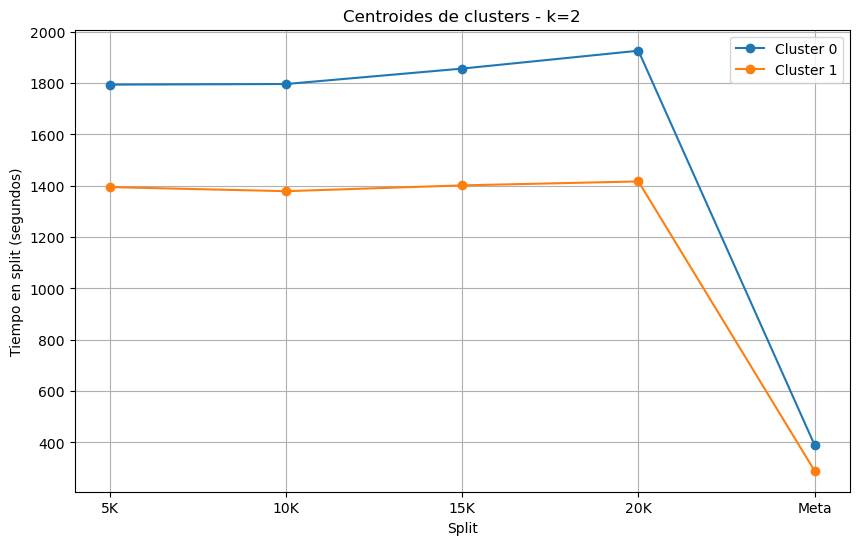

In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

ordered_splits = ['5K', '10K', '15K', '20K', 'Meta']
split_cols_1 = ordered_splits  # usar solo estas columnas para clustering
X = df_wide[split_cols_1]

split_cols = [c for c in X.columns if c not in ['athlete_id', 'race_id', 'event_id', 'gender', 'age']]
X = df_wide[split_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
best_score = -1
best_k = None
best_labels = None
best_model = None

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, silhouette_score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
        best_model = kmeans

print(f"\nMejor k según Silhouette: {best_k} (score={best_score:.4f})")

df_wide['cluster'] = best_labels

centroids = scaler.inverse_transform(best_model.cluster_centers_)

plt.figure(figsize=(10,6))
for i, centroid in enumerate(centroids):
    plt.plot(split_cols, centroid, marker='o', label=f'Cluster {i}')
plt.xlabel("Split")
plt.ylabel("Tiempo en split (segundos)")
plt.title(f"Centroides de clusters - k={best_k}")
plt.legend()
plt.grid(True)
plt.show()


k=2, BIC=27927.33
k=3, BIC=10259.87
k=4, BIC=3884.53
k=5, BIC=1713.98
k=6, BIC=1829.56
k=7, BIC=1156.16
k=8, BIC=1137.90
k=9, BIC=698.47
k=10, BIC=248.29
k=12, BIC=689.12
k=15, BIC=358.21

Mejor k según BIC: 10


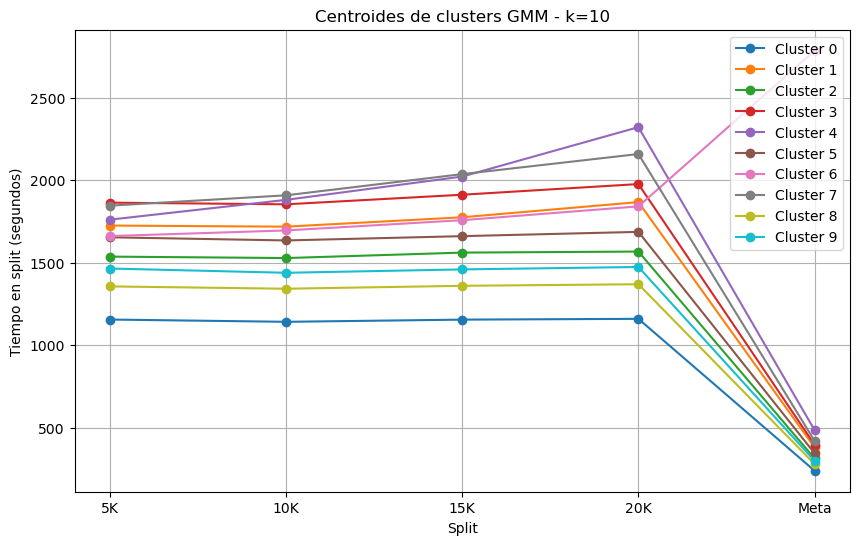

In [37]:
from sklearn.mixture import GaussianMixture
import numpy as np

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
lowest_bic = np.inf
best_gmm = None
bic_scores = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    bic_scores.append(bic)
    print(f"k={k}, BIC={bic:.2f}")
    
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm

print(f"\nMejor k según BIC: {best_gmm.n_components}")

labels_gmm = best_gmm.predict(X_scaled)
df_wide['cluster_gmm'] = labels_gmm

probs_gmm = best_gmm.predict_proba(X_scaled)
centroids_gmm = scaler.inverse_transform(best_gmm.means_)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for i, centroid in enumerate(centroids_gmm):
    plt.plot(split_cols, centroid, marker='o', label=f'Cluster {i}')
plt.xlabel("Split")
plt.ylabel("Tiempo en split (segundos)")
plt.title(f"Centroides de clusters GMM - k={best_gmm.n_components}")
plt.legend()
plt.grid(True)
plt.show()

Bandwidth estimado: 1.1979
Número de clusters encontrados: 49


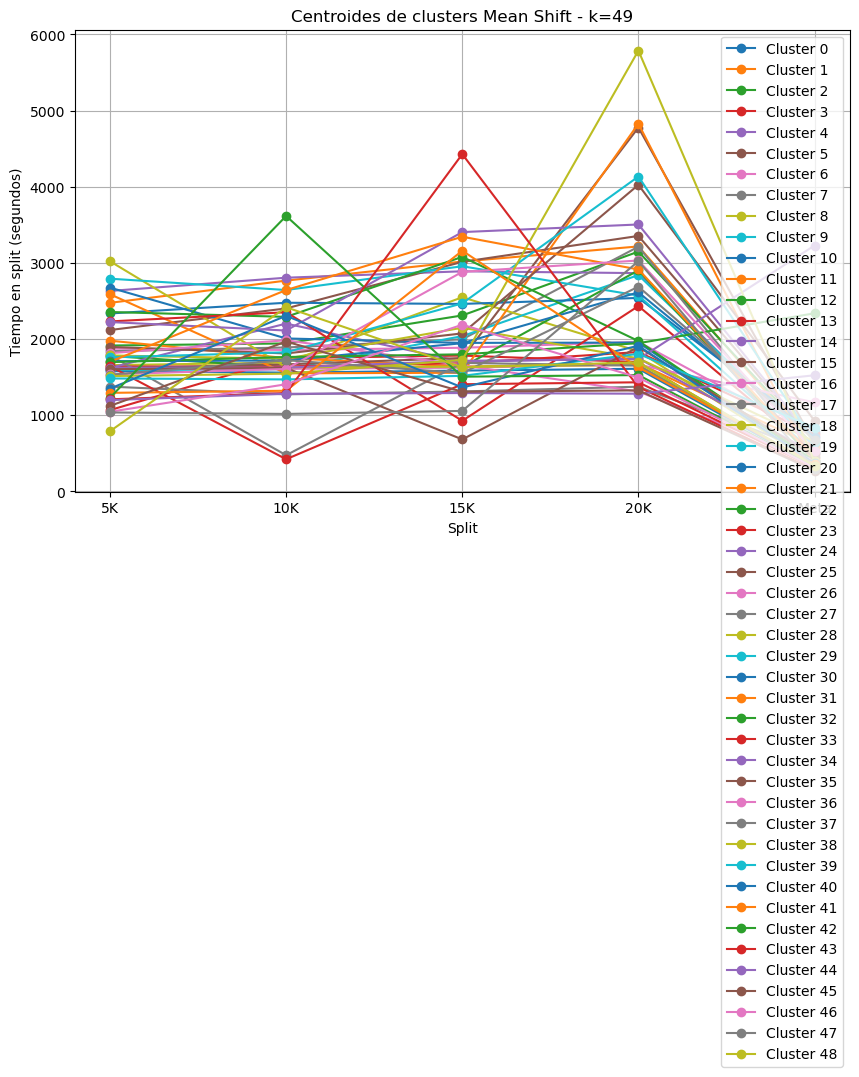

In [38]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=5000)
print(f"Bandwidth estimado: {bandwidth:.4f}")

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_scaled)

labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels_ms))
print(f"Número de clusters encontrados: {n_clusters_}")

df_wide['cluster_meanshift'] = labels_ms

centroids_ms = scaler.inverse_transform(cluster_centers)

plt.figure(figsize=(10,6))
for i, centroid in enumerate(centroids_ms):
    plt.plot(split_cols, centroid, marker='o', label=f'Cluster {i}')
plt.xlabel("Split")
plt.ylabel("Tiempo en split (segundos)")
plt.title(f"Centroides de clusters Mean Shift - k={n_clusters_}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import hdbscan
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=75,     
    min_samples=15,        
    cluster_selection_epsilon=0.1, 
    gen_min_span_tree=True
)

labels = clusterer.fit_predict(X_pca)

# Filtrar ruido
mask = labels != -1
X_clustered = X_pca[mask]
labels_clustered = labels[mask]

if len(set(labels_clustered)) > 1:
    sil = silhouette_score(X_clustered, labels_clustered)
else:
    sil = None

print("Clusters encontrados:", len(set(labels)) - (1 if -1 in labels else 0))
print("Porcentaje de ruido:", np.mean(labels == -1))
print("Silhouette (solo clusters):", sil)


Clusters encontrados: 2
Porcentaje de ruido: 0.8279138997023128
Silhouette (solo clusters): 0.410312976843798
